# Median Household Income as it relates to Median Housing Unit Value in Brooklyn, NY 2015-2020

<p style="text-align:center;"> <img src="https://www.osc.state.ny.us/files/reports/image/brooklyn-labeled-map-v2.png" style="width: 300px"/>Map of Brooklyn (1)</p>

The goal of this notebook is to understand the household income distribution, income changes and how this correlates with housing values for all census tracts in Brooklyn, NY from 2015-2020. Several data sources were used to answer these questions, the primary data source being the American Community Survey (ACS) 5 year estimates.

The American Community Survey puts out 5 year estimates every year. However these estimates are collected on a rolling 5 year basis meaning that the 2015 ACS 5-year estimates countains data collected from 2011-2015, the 2017 ACS 5-year estimates countain data collected from 2013-2017 and so on.

As a result the Census Bureau strongly recommends against comparing estimates in overlapping 5-year periods since much of the data in each survey are the same. Instead, the Census Bureau encourages data users to compare 5-year estimates that don’t have any overlapping years of data. (2)

For the purpose of analyzing median household income changes over the last 5 years, the 2020 ACS 5-year estimates (the most recent survey) and the 2015 ACS 5-year estimates were used. (3)

## Preparing the dataset

#### API call to ingest the variables needed from the American Community Survey (ACS) to show income increase or decrease

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as cx

#US 2020 5 Year Census API call for Kings County (Brooklyn) NY 
api_key = "7369adb64373951f80f4f1816f9c54f808f59a40"
calledAPI_2020 = f"https://api.census.gov/data/2020/acs/acs5?get=B19013_001E,B25107_001E,B23025_005E,B23025_002E&for=tract:*&in=state:36&in=county:047&key={api_key}"
response_2020 = requests.get(calledAPI_2020)
formattedResponse_2020 = json.loads(response_2020.text)[1:]

#US 2015 5 Year Census API call for Kings County (Brooklyn) NY 
calledAPI_2015 = f"https://api.census.gov/data/2015/acs/acs5?get=B19013_001E,B25107_001E,B23025_005E,B23025_002E&for=tract:*&in=state:36&in=county:047&key={api_key}"
response_2015 = requests.get(calledAPI_2015)
formattedResponse_2015 = json.loads(response_2015.text)[1:]

#store the 2020 and 2015 responses in dataframe, add housing percentage cost variable
bk_tract_df_2020 = pd.DataFrame(columns=['Median_12_Mo_HH_Income', 'Median_Unit_Value', 'Total_Unemployed', 'Total_Labor_Force','State', 'County', 'Tract'], data=formattedResponse_2020)
bk_tract_df_2015 = pd.DataFrame(columns=['Median_12_Mo_HH_Income', 'Median_Unit_Value', 'Total_Unemployed', 'Total_Labor_Force','State', 'County', 'Tract'], data=formattedResponse_2015)

print(bk_tract_df_2020.head())

  Median_12_Mo_HH_Income Median_Unit_Value Total_Unemployed Total_Labor_Force  \
0                  41563            696600              110              1604   
1                  51346            967900               55               998   
2                  58750            588000               27              1429   
3                  62614            922800              218              3258   
4                  56229           1076800              150              3219   

  State County   Tract  
0    36    047  009202  
1    36    047  009401  
2    36    047  009402  
3    36    047  009600  
4    36    047  009800  


Two API calls were written, to ingest both the 2020 and 2015 survey data in dataframes at the census tract level. Bouroughs are not supported census geographies, however since Brooklyn is coterminus with Kings County (047), we can pull our data at the county level. We need the same variables from both years to compare change over time. The variables that were pulled from the census surveys include:
* Median 12 Month Household income (adjusted for inflation)
* Median Housing Unit Value
* Total Unemployed Population in the Labor Force
* Total Labor Force Population
* State
* County
* Tract

It's essential to use the median in this type of analysis because it is less affected by outliers and skewed data than the mean. The median is usually the preferred measure of central tendency when the distribution is not symmetrical, which is typically the case with income distribtuions.

#### Merge the 2015 and 2020 dataframes and clean up the data

In [2]:
#merge to one dataframe, convert to int, replacing dummy values
bk_tract_df_merged = bk_tract_df_2020.merge(bk_tract_df_2015, how='outer', on=['State', 'County', 'Tract'], suffixes=['_2020','_2015'])
bk_tract_df_merged.fillna(-666666666, inplace = True)
bk_tract_df_merged = bk_tract_df_merged.astype({
    'Median_12_Mo_HH_Income_2020':'int','Median_Unit_Value_2020':'int', 'Total_Unemployed_2020':'int', 'Total_Labor_Force_2020': 'int',
    'Median_12_Mo_HH_Income_2015':'int','Median_Unit_Value_2015':'int', 'Total_Unemployed_2015':'int', 'Total_Labor_Force_2015': 'int'})
bk_tract_df_merged = bk_tract_df_merged.replace(-666666666, np.NaN)

Variables in the survey data contain dummy values in the form of "-666666666". To clean the data set NULLs were populated with the dummy value, all columns that would be included in calculation were converted to int, and the dummy values were replaced with NaN.

#### Adjust 2015 Income data for inflation, add variable change over time as dataframe columns

In [3]:
#adjusting 2015 income for inflation, add change over time variables
bk_tract_df_merged['Median_12_Mo_HH_Income_2015'] = round(bk_tract_df_merged['Median_12_Mo_HH_Income_2015'].mul(1.09257667), 2)
bk_tract_df_merged['Unemployment_Rate_2020'] = round((bk_tract_df_merged['Total_Unemployed_2020'] / bk_tract_df_merged['Total_Labor_Force_2020']) * 100, 2)
bk_tract_df_merged['Median_12_Mo_HH_Income_Change'] = bk_tract_df_merged['Median_12_Mo_HH_Income_2020'] - bk_tract_df_merged['Median_12_Mo_HH_Income_2015']

print(bk_tract_df_merged.head())

   Median_12_Mo_HH_Income_2020  Median_Unit_Value_2020  Total_Unemployed_2020  \
0                      41563.0                696600.0                  110.0   
1                      51346.0                967900.0                   55.0   
2                      58750.0                588000.0                   27.0   
3                      62614.0                922800.0                  218.0   
4                      56229.0               1076800.0                  150.0   

   Total_Labor_Force_2020 State County   Tract  Median_12_Mo_HH_Income_2015  \
0                  1604.0    36    047  009202                          NaN   
1                   998.0    36    047  009401                          NaN   
2                  1429.0    36    047  009402                          NaN   
3                  3258.0    36    047  009600                     35868.20   
4                  3219.0    36    047  009800                     34919.84   

   Median_Unit_Value_2015  Total_Unemp

The last step in setting up this data for analysis is to adjust the 2015 income values for inflation and calculate the change in our key variables over time. According to the US Census 5-year to 5-year comparison guide:

> Income and earnings estimates in the 2011-2015 ACS 5-year data set are inflation-adjusted to 2015 dollars. Income and earnings estimates in the 2016-2020 ACS 5-year data set are inflation-adjusted to 2020 dollars. To compare income estimates between the two, multiply the 2011-2015 dollar estimates by 1.09257667 (CPI-U-RS) in order to inflation-adjust 2015 dollars to 2020 dollars.(4)

## Question 1a: Has income increased or decreased over the last 5 years?

#### Calculate income changes over time 

In [4]:
#How has income shifted generally? - Mean Likely skewed to the right - with a longer tail in the high income end
median_income_2015 = round(bk_tract_df_merged['Median_12_Mo_HH_Income_2015'].median(skipna = True),2)
median_income_2020 = round(bk_tract_df_2020['Median_12_Mo_HH_Income'].median(skipna = True),2)
median_income_change = median_income_2020 - median_income_2015
pct_income_increase = round((median_income_change / median_income_2015) * 100, 2)

#bk_tract_df_merged.to_csv('bk_housing_income_by_tract_merged.csv', index=False)
print('2020 median income = ', median_income_2020)
print('2015 median income (in 2020 dollars) = ', median_income_2015)
print('Change in median income = ', median_income_change)
print('Percent change = ', pct_income_increase)

2020 median income =  63507.0
2015 median income (in 2020 dollars) =  52879.07
Change in median income =  10627.93
Percent change =  20.1


Now that the dataframe is set up for analysis, how has yearly household income changed generally in Brooklyn over the last 5 years? The median income has increased \\$10,627.93, about 20.1%.

While I can comfortably say income has *generally* increased, this doesn't tell the whole story.

#### Plot 2015 and 2020 median income density distribution to show change

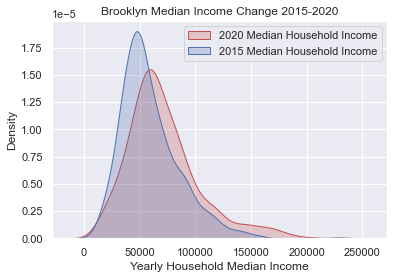

In [5]:
%matplotlib inline
sns.set(style="darkgrid")

income_change_fig = sns.kdeplot(bk_tract_df_merged['Median_12_Mo_HH_Income_2020'], shade=True, color="r")
income_change_fig = sns.kdeplot(bk_tract_df_merged['Median_12_Mo_HH_Income_2015'], shade=True, color="b")
plt.legend(labels=["2020 Median Household Income","2015 Median Household Income"])
income_change_fig.set_title('Brooklyn Median Income Change 2015-2020')
income_change_fig.set_xlabel('Yearly Household Median Income')
plt.show()

#### Plot histogram of median income change by tract to show change amounts

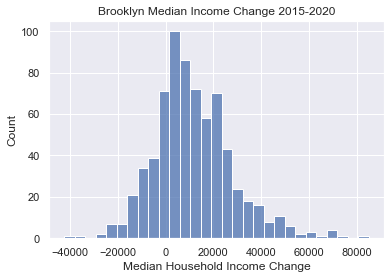

In [6]:
sns.set(style="darkgrid")
income_change_fig = sns.histplot(bk_tract_df_merged['Median_12_Mo_HH_Income_Change'])
income_change_fig.set_title('Brooklyn Median Income Change 2015-2020')
income_change_fig.set_xlabel('Median Household Income Change')
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

These density plots show that while the median income does appear to be a good measure of central tendency, and it has increased over the last 5 years, both of these distributions are skewed to the right with a long tail at the higher income end of the axis. Additionally, the histogram shows there is a divergence in this data, where a sizeable portion of the households have actually seen decreases in household income over the last five years. We can plot this data spatially to better understand what is happening.

## Question 1b: Is this pattern consistent across all census tracts? If not, what are the divergences?

#### Ingest NY shapefile data, plot a choropleth graph

C:\Users\zach.shamroukh\Python\envs\NFG_ENV\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


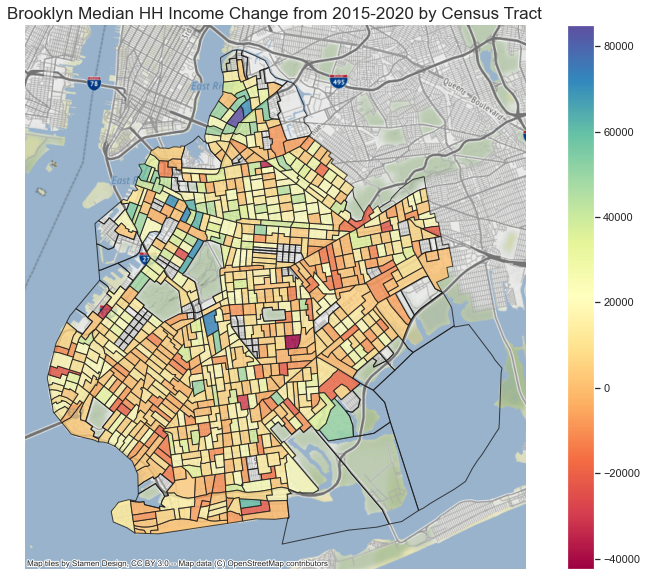

In [7]:
#pulling in polygons for plotting, merging with census data
NY_shp_df = gpd.read_file('cb_2020_36_tract_500k.shp')
BK_shp_df = NY_shp_df[NY_shp_df.COUNTYFP == '047']
BK_mapping_df = BK_shp_df.merge(bk_tract_df_merged, how='left', left_on='TRACTCE', right_on='Tract')

BK_mapping_df_wm = BK_mapping_df.to_crs(epsg=3857)

#ax = BK_mapping_df_wm.plot(alpha=0.5, edgecolor='k')
ax = BK_mapping_df_wm.plot(column = 'Median_12_Mo_HH_Income_Change', legend = True, cmap = 'Spectral', edgecolor='k', alpha=0.8)
cx.add_basemap(ax)

plt.rcParams['figure.figsize'] = [30, 20]
plt.title('Brooklyn Median HH Income Change from 2015-2020 by Census Tract', fontsize = 17)
plt.axis('off')
plt.show()

This chorpleth map shows a clear regional divergence in income across the borough, with income increasing drastically in the affluent northern and western neighborhoods such as Williamsburg and Brooklyn Heights. The neighborhoods surrounding these areas also saw signifigant increases, though not as dramatic, with the change in median income steadily declining as you move south and east. Written about extensively, regional divergence in New York city has been attributed to job growth at opposite ends of the wage spectrum since the 2008 financial crisis. From 2009 to 2018, the two fastest growing industries were hospitality/accommodation/food-related services and professional/technical services, fields with vastly different levels of compensation and job security (5). 

Make no mistake, regional divergence is much more than economics. The families on the opposite ends of this spectrum look very different from those at the top, but for the sake of this exercise and time constraints only the economic factors were taken into account here.

## Question 1c: What other variables can explain this regional divergence?

American census data around employment, specifically the growth of employment sectors by neighborhood in Brooklyn, supports the idea of the deepening regional divergence and confirms my geospatial analysis in the bourough:

> Among Brooklyn’s neighborhoods, the three with the most employment in 2019 (together accounting for more than one-third of all jobs in the borough) were Brooklyn Heights/Fort Greene, Borough Park/Kensington/Ocean Parkway and Greenpoint/Williamsburg. The three neighborhoods with the fewest jobs were Crown Heights South/Prospect Lefferts/Wingate, Brownsville/Ocean Hill and East Flatbush/Farragut/Rugby. (1)


## Question 2a - Is there a correlation between the median housing unit value and the median household income?

#### Compare income to housing value on a scatterplot and solve for r

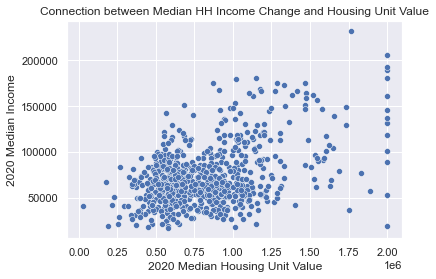

2020 Income/Value Correlation: 0.43


In [8]:
#plotting scatter plot for income x value correlation
%matplotlib inline
income_value_scatter = sns.scatterplot(data=bk_tract_df_merged, x="Median_Unit_Value_2020", y="Median_12_Mo_HH_Income_2020")
income_value_scatter.set_title('Connection between Median HH Income Change and Housing Unit Value')
income_value_scatter.set_xlabel('2020 Median Housing Unit Value')
income_value_scatter.set_ylabel('2020 Median Income')
plt.show()

# Correlation
corr_2020 = bk_tract_df_merged['Median_12_Mo_HH_Income_2020'].corr(bk_tract_df_merged['Median_Unit_Value_2020'])

print ('2020 Income/Value Correlation:', round(corr_2020, 2))

We can calculate and visulaize the correlation between 2020 housing value and income in Brooklyn with a scatter plot and the correlation function. This scatterplot shows a weak to moderate positive correlation between these two values, confirmed with the calculation of the Pearson correlation coefficient where r = 0.43.

## Question 2b - What other variables affect Housing Unit Value and income?

#### Compare unemployment to housing value on a scatterplot and solve for r

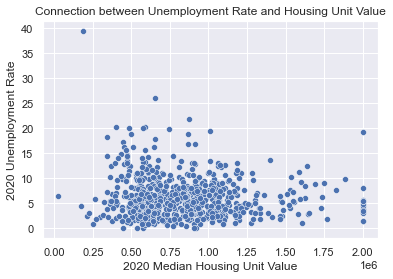

2020 Unemployment/Value Corr: -0.09


In [9]:
%matplotlib inline
sns.set(style="darkgrid")
pop_value_scatter = sns.scatterplot(data=bk_tract_df_merged, x="Median_Unit_Value_2020", y="Unemployment_Rate_2020")
pop_value_scatter.set_title('Connection between Unemployment Rate and Housing Unit Value')
pop_value_scatter.set_xlabel('2020 Median Housing Unit Value')
pop_value_scatter.set_ylabel('2020 Unemployment Rate')
plt.show()

# Correlation
corr_2020 = bk_tract_df_merged['Unemployment_Rate_2020'].corr(bk_tract_df_merged['Median_Unit_Value_2020'])

print ('2020 Unemployment/Value Corr:', round(corr_2020, 2))

#### Compare unemployment to median income on a scatterplot and solve for r

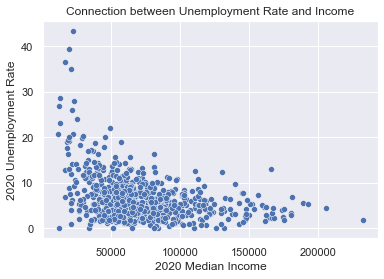

2020 Unemployment/Income Corr: -0.37


In [10]:
%matplotlib inline
sns.set(style="darkgrid")
pop_value_scatter = sns.scatterplot(data=bk_tract_df_merged, x="Median_12_Mo_HH_Income_2020", y="Unemployment_Rate_2020")
pop_value_scatter.set_title('Connection between Unemployment Rate and Income')
pop_value_scatter.set_xlabel('2020 Median Income')
pop_value_scatter.set_ylabel('2020 Unemployment Rate')
plt.show()

#Correlation
income_unemployment_r = bk_tract_df_merged['Unemployment_Rate_2020'].corr(bk_tract_df_merged['Median_12_Mo_HH_Income_2020'])

print ('2020 Unemployment/Income Corr:', round(income_unemployment_r, 2))

As to be expected unemployment and income are negatively correlated, albeit moderately, as unemployment decreases income increases. However somewhat surprisingly unemployment and housing value don't appear to be correlated, with a very slight negative correlation if any. This surprising given analysis accross the US showing moderate negative correlations between unemployment and housing values. 

## Challenges

This analysis was difficult to properly conduct due to the age of the dataset. With drastic changes to the economy over the last two years during covid, the most recent reliable data being from 2020 makes it difficult to properly represent these changes and variables. On top of that changes to income and housing values are complex values, no one variable will perfectly correlate with either of these economic indicators since there are so many levers to pull. Additional variables I would incorporate into this analysis given more time would be crime rates, education, number of hospitals and distance to transit to name a few.   

## Conclusion 

The American Community Survey 5 year estimates from 2020 and 2015 show a general increase in wages of about 20 percent across Brooklyn from 2015-2020. However, as I dove deeper into the data I discovered regional divergences accross the census tracts with median increases upwards of \\$80,000 in the more affluent neighborhoods such as Williamsburg and decreases south of $40,000 in southern Crown Heights.

Regional divergence in income can be attributed to many factors across NY and the US as a whole: class, race, job sector growth, and education among them. Written about extensively, regional income divergence in New York city has been attributed to job growth at opposite ends of the wage spectrum since the 2008 financial crisis. From 2009 to 2018, the two fastest growing industries were hospitality/accommodation/food-related services and professional/technical services, fields with vastly different levels of compensation and job security (5).

Additionally, income and it's drastic changes are moderately positively correlated with housing prices accross the bourough. Which makes sense, but what other variables affect housing prices? Contrary to the general consensus in academic literature on the internet, I did not find a strong negative correlation between unemployment and housing. However, limitations in these census survey include lack of responses on certain sensitive subjects as employment and wages which could be skewing this result. I did predictably find a moderate negative correlation between unemployment and wages.

I would like to do deeper analysis on this topic, specifically around the largest variance between housing unit value and wages. If one could identify were income or change of income is high, while housing unit value is still low and yet to catch up, this could potentially offer valuable insights to potential homeowners.

## Citations

1. Recent Trends and Impact of COVID-19 in Brooklyn, Office of NYS Comptroller -  https://www.osc.state.ny.us/reports/osdc/recent-trends-and-impact-covid-19-brooklyn

2. Period Estimates in the American Community Survey, US Census Bureau - https://www.census.gov/newsroom/blogs/random-samplings/2022/03/period-estimates-american-community-survey.html

3. American Community Survey 5 Year Estimates, US Census Bureau - https://www.census.gov/data/developers/data-sets/acs-5year.html

4. Comparing ACS Data, US Census Bureau - https://www.census.gov/programs-surveys/acs/guidance/comparing-acs-data/2020/5-year-comparison.html

5. City Limits - https://citylimits.org/2020/10/06/opinion-nycs-growing-income-inequality-threatens-pandemic-recovery/#:~:text=One%20reason%20for%20sustained%20income,services%20and%20professional%2Ftechnical%20services